In [82]:
!pip install transformers
!pip install pyspellchecker
!pip install sentencepiece

In [83]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch
from google.colab import files
import pandas as pd
import io
import seaborn as sb
from transformers import pipeline
from transformers import AutoModelWithLMHead, AutoTokenizer

# Loading in Podcast Descriptions

In [84]:
#reading in podcast descriptions data
uploaded = files.upload()

Saving podcast.csv to podcast (2).csv


In [85]:
#setting up df
podcast_df = pd.read_csv(io.BytesIO(uploaded['podcast.csv']))

# Creating Abstract Summary with Pegasus

In [86]:
model_name = 'google/pegasus-xsum'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

In [87]:
#Making pegasus summary and appending into a list
short_summary = []
for i in range(41):
  batch = tokenizer.prepare_seq2seq_batch(podcast_df['description'][i], truncation=True, padding='longest', return_tensors='pt').to(torch_device)
  translated = model.generate(**batch)
  tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
  short_summary.append(str(tgt_text[0]))

In [88]:
#Making Pegasus summary list into a column in my df
podcast_df['pegasus_summary'] = short_summary

In [89]:
#Getting original length vs pegasus length and making new columns
podcast_df["original_length"] = 0
podcast_df["pegasus_length"] = 0

for j in range(41):
  podcast_df["original_length"][j] = len(podcast_df['description'][j])
  podcast_df["pegasus_length"][j] = len(podcast_df['pegasus_summary'][j])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [90]:
#Creating column for summary ratio
podcast_df['summary_ratio_peg'] = podcast_df['pegasus_length'] / podcast_df['original_length']

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Input Distribution / Summary Length Distribution')

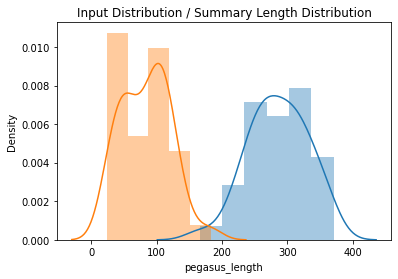

In [91]:
#Looking at the distplot for original length vs pegasus length
sb.distplot(podcast_df['original_length'])
sb.distplot(podcast_df['pegasus_length']).set_title('Input Distribution / Summary Length Distribution')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Summary Ratio Distribution')

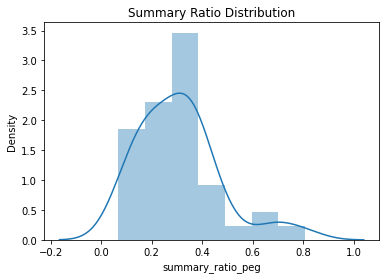

In [92]:
#Looking at the distplot for summary ratio
sb.distplot(podcast_df['summary_ratio_peg']).set_title('Summary Ratio Distribution')

# Creating Extractive Summary with Google T5

In [93]:
# Setting up model and tokenizer for google T5
model = AutoModelWithLMHead.from_pretrained("t5-base")
tokenizer = AutoTokenizer.from_pretrained("t5-base")

/usr/local/lib/python3.6/dist-packages/transformers/models/auto/modeling_auto.py:970: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [94]:
#Creating t5 summerization
t5_sum = []
for des in podcast_df['description']:
  inputs = tokenizer.encode("summarize: " + des, return_tensors="pt")
  outputs = model.generate(inputs, max_length=26, min_length=12, length_penalty=2.0, num_beams=4, early_stopping=True)
  t5_sum.append(tokenizer.decode(outputs[0]))

In [95]:
podcast_df['t5_summary'] = t5_sum

# Exporting to csv

In [98]:
# Import Drive API and authenticate.
from google.colab import drive

# Mount your Drive to the Colab VM.
drive.mount('/gdrive', force_remount=True)

# Write the DataFrame to CSV file.
with open('/gdrive/My Drive/podcast_with_summary.csv', 'w') as f:
  podcast_df.to_csv(f)

Mounted at /gdrive


In [99]:
podcast_df.to_csv(r'podcast_with_summary.csv')